# VAE Troubleshooting –– 3

WNixalo – 2016/6/24-5

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai.conv_learner import *

## 1. Setup

In [3]:
input_size   = 784
encoding_dim = 32
bs = 16
tfm0 = torchvision.transforms.ToTensor()  # convert [0,255] -> [0.0,1.0]

In [4]:
train_dataset = torchvision.datasets.MNIST('data/MNIST/',train=True, transform=tfm0)
test_dataset  = torchvision.datasets.MNIST('data/MNIST/',train=False,transform=tfm0)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=bs)

In [5]:
# create copies of dataloaders for ModelData
train_loadermd = copy.deepcopy(train_loader)
test_loadermd  = copy.deepcopy(test_loader)

# set y to be x and convert [0,255] int to [0.0,1.0] float. (dl doesnt trsfm `y` by default)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_data.type(torch.FloatTensor)/255
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_data.type(torch.FloatTensor)/255

# add channel dimension for compatibility. (bs,h,w) –> (bs,ch,h,w)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_labels.reshape((len(train_loadermd.dataset),1,28,28))
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_labels.reshape((len(test_loadermd.dataset),1,28,28))

In [6]:
md = ModelData('data/MNIST', train_loadermd, test_loadermd)

### visuals

In [22]:
def compare_batch(x, z, bs=16, figsize=(16,2)):
    bs = min(len(x), bs) # digits to display
    fig = plt.figure(figsize=figsize)
    for i in range(bs):
        # display original
        ax = plt.subplot(2, bs, i+1); ax.imshow(x[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, bs, i+1+bs); ax.imshow(z[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
def space_plot(model):
    model.eval()
    plt.figure(figsize=(6,6)); plt.style.use('classic');

    for x,y in iter(test_loader):
        z, μ, logvar, enc_x = model(x)

        plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
    plt.colorbar(); plt.style.use('default');
    
def model_plots(model, dataloader):
    x,y = next(iter(dataloader))
    z = model(x)
    if len(z) > 1: print([zi.shape for zi in z]);
    compare_batch(x,z[0].detach())
    space_plot(model)

### architecture

In [8]:
# working pytorch example
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [48]:
# my version I'm trying to get to work
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0  = nn.Linear(784,512)
        self.fc10 = nn.Linear(512,2)
        self.fc11 = nn.Linear(512,2)
    def forward(self, x):
        h1 = F.relu(self.fc0(x))
        mu,logv = self.fc10(h1), self.fc11(h1)
        return mu, logv

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc2 = nn.Linear(2,512)
        self.fc3 = nn.Linear(512,784)
    def forward(self, x):
        h3 = F.relu(self.fc2(x))
        z  = F.sigmoid(self.fc3(h3))
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def reparameterize(self, mu, logv):
        if self.training:
            sig = torch.exp(0.5*logv)
            eps = torch.randn_like(sig)
            return eps*sig + mu ## eps.mul(sig).add_(mu)
#             return eps.mul(sig).add_(mu)
        else: return mu
    def forward(self, x):
        shape = x.shape
        x = x.view(x.size(0),-1)
        mu, logv = self.encoder(x)
        h = self.reparameterize(mu,logv)
        z = self.decoder(h)
        z = z.view(z.size(0), *shape[1:])
#         z = z.view(z.size(0),1,28,28)
        return z, mu, logv, h

### loss function

In [38]:
def bce_flat(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=True)
def vae_loss(output, xtra, raw_loss):
    mu,logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5 * torch.sum(1 + logv - mu**2 - torch.exp(logv))
#     KLD = -0.5 * torch.sum(1 + logv - mu.pow(2) - torch.exp(logv))
    return BCE + KLD

## testing

In [41]:
learner = Learner.from_model_data(VariationalAutoencoder(), md)

# learner.crit = bce_flat
learner.crit = F.binary_cross_entropy
learner.opt_fn = torch.optim.Adam
learner.reg_fn = vae_loss

In [42]:
learner.fit(1e-3, 1)

epoch      trn_loss   val_loss                                 
    0      0.265498   0.263317  


[0.2633170844554901]

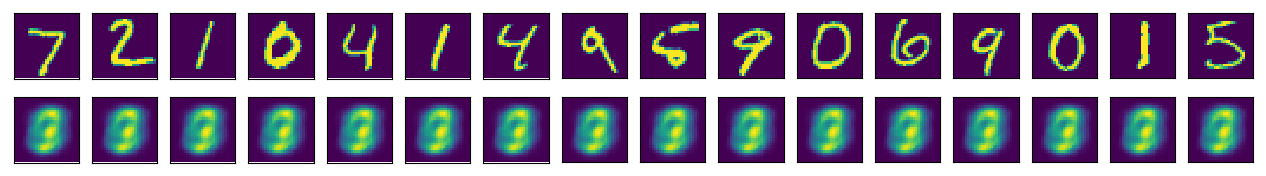

In [43]:
x,y = next(iter(learner.data.val_dl))
z = learner.predict()
compare_batch(x,z)

In [44]:
learner.model(x)[1]

tensor(1.00000e-04 *
       [[-0.2166, -3.0556],
        [-0.3899,  1.0751],
        [-2.2802, -3.6173],
        [ 3.4942,  1.5176],
        [-2.1407, -3.3926],
        [-1.5283, -1.4644],
        [-2.8723, -6.1778],
        [ 0.6526,  3.1924],
        [ 1.1581,  5.6805],
        [ 3.0446,  2.3714],
        [-0.9516, -6.0043],
        [-1.5701, -1.3463],
        [-0.2928, -2.2814],
        [ 2.4222,  4.7411],
        [-0.4119, -0.3210],
        [-0.6501, -0.7281]])

In [45]:
learner.model(x)[2]

tensor(1.00000e-04 *
       [[-0.1187,  0.5283],
        [-0.0009, -0.4885],
        [-0.3968,  0.4135],
        [-0.0641, -1.8501],
        [-0.8194,  0.1361],
        [-0.4347,  0.3836],
        [-0.5508,  1.5599],
        [-0.8609, -0.9070],
        [-0.9438, -2.0088],
        [ 0.5038,  0.4371],
        [-0.0884,  0.2428],
        [-0.4133,  1.0398],
        [-0.1329,  0.0136],
        [ 0.1136, -0.5437],
        [-0.3695,  0.1436],
        [-0.2638, -0.2919]])

In [46]:
len(learner.model(x))

3

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, data, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), 
                                 size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(epoch, log_interval=800):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, enc = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
for i in range(3): train(i+1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 553.154480
Train Epoch: 1 [12800/60000 (21%)]	Loss: 190.366409
Train Epoch: 1 [25600/60000 (43%)]	Loss: 190.912125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 189.457825
Train Epoch: 1 [51200/60000 (85%)]	Loss: 187.790329
====> Epoch: 1 Average loss: 190.8983
Train Epoch: 2 [0/60000 (0%)]	Loss: 189.973785
Train Epoch: 2 [12800/60000 (21%)]	Loss: 189.892120
Train Epoch: 2 [25600/60000 (43%)]	Loss: 190.003647
Train Epoch: 2 [38400/60000 (64%)]	Loss: 188.956284
Train Epoch: 2 [51200/60000 (85%)]	Loss: 189.250732
====> Epoch: 2 Average loss: 189.0501
Train Epoch: 3 [0/60000 (0%)]	Loss: 189.335938
Train Epoch: 3 [12800/60000 (21%)]	Loss: 189.350998
Train Epoch: 3 [25600/60000 (43%)]	Loss: 188.867096
Train Epoch: 3 [38400/60000 (64%)]	Loss: 188.969910
Train Epoch: 3 [51200/60000 (85%)]	Loss: 189.617340
====> Epoch: 3 Average loss: 188.9746


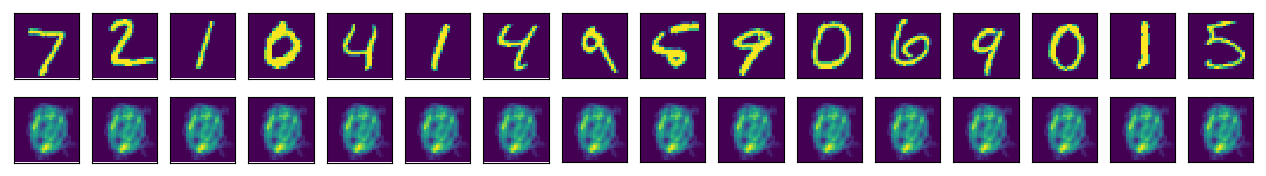

In [56]:
x,y = next(iter(learner.data.val_dl))
z = model(x)
compare_batch(x,z[0].detach())

In [64]:
z[1]

tensor(1.00000e-02 *
       [[-1.2499, -5.1417],
        [ 2.3675,  0.8045],
        [ 2.3192,  0.0512],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.7798,  0.6624],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.2529,  1.5025],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188],
        [ 1.7318,  0.7188]])

In [65]:
z[2]

tensor([[ 0.0227, -0.1002],
        [ 0.0040, -0.0657],
        [-0.0094, -0.0518],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0116, -0.0510],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0185, -0.0437],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510],
        [-0.0108, -0.0510]])

Train Epoch: 4 [0/60000 (0%)]	Loss: 189.154480
Train Epoch: 4 [12800/60000 (21%)]	Loss: 188.641403
Train Epoch: 4 [25600/60000 (43%)]	Loss: 188.868195
Train Epoch: 4 [38400/60000 (64%)]	Loss: 189.226257
Train Epoch: 4 [51200/60000 (85%)]	Loss: 188.799713
====> Epoch: 4 Average loss: 188.9718
Train Epoch: 5 [0/60000 (0%)]	Loss: 188.615677
Train Epoch: 5 [12800/60000 (21%)]	Loss: 188.987137
Train Epoch: 5 [25600/60000 (43%)]	Loss: 189.601944
Train Epoch: 5 [38400/60000 (64%)]	Loss: 188.661209
Train Epoch: 5 [51200/60000 (85%)]	Loss: 189.133759
====> Epoch: 5 Average loss: 188.9707
Train Epoch: 6 [0/60000 (0%)]	Loss: 188.912766
Train Epoch: 6 [12800/60000 (21%)]	Loss: 188.969727
Train Epoch: 6 [25600/60000 (43%)]	Loss: 189.306595
Train Epoch: 6 [38400/60000 (64%)]	Loss: 189.097458
Train Epoch: 6 [51200/60000 (85%)]	Loss: 189.095093
====> Epoch: 6 Average loss: 188.9699


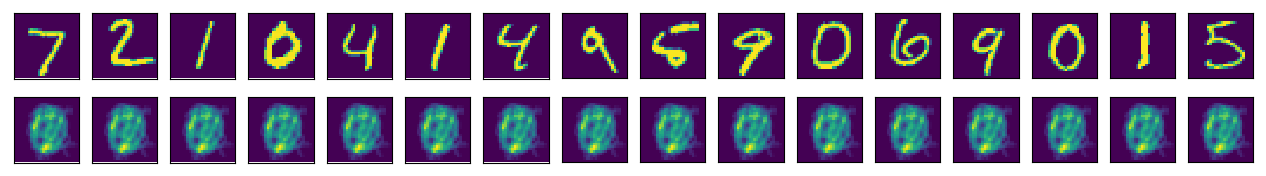

In [66]:
for i in range(3,6): train(i+1)
x,y = next(iter(learner.data.val_dl))
z = model(x)
compare_batch(x,z[0].detach())

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, data, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), 
                                 size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(epoch, log_interval=800):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
for i in range(3): train(i+1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.842896
Train Epoch: 1 [12800/60000 (21%)]	Loss: 187.940292
Train Epoch: 1 [25600/60000 (43%)]	Loss: 190.534714
Train Epoch: 1 [38400/60000 (64%)]	Loss: 187.140732
Train Epoch: 1 [51200/60000 (85%)]	Loss: 187.751999
====> Epoch: 1 Average loss: 191.6934
Train Epoch: 2 [0/60000 (0%)]	Loss: 188.488739
Train Epoch: 2 [12800/60000 (21%)]	Loss: 187.909744
Train Epoch: 2 [25600/60000 (43%)]	Loss: 191.537766
Train Epoch: 2 [38400/60000 (64%)]	Loss: 189.849686
Train Epoch: 2 [51200/60000 (85%)]	Loss: 188.942276
====> Epoch: 2 Average loss: 189.4090
Train Epoch: 3 [0/60000 (0%)]	Loss: 187.391159
Train Epoch: 3 [12800/60000 (21%)]	Loss: 189.502975
Train Epoch: 3 [25600/60000 (43%)]	Loss: 189.077652
Train Epoch: 3 [38400/60000 (64%)]	Loss: 188.673752
Train Epoch: 3 [51200/60000 (85%)]	Loss: 189.236053
====> Epoch: 3 Average loss: 189.1310


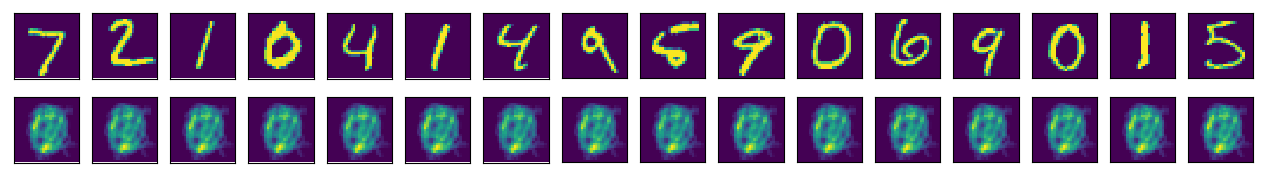

In [78]:
x,y = next(iter(learner.data.val_dl))
z = model(x)
compare_batch(x,z[0].detach())

In [70]:
z[1]

tensor(1.00000e-02 *
       [[-1.4008, -0.3753,  0.3490, -1.1406,  0.5631,  0.0779,  0.2010,
          0.2237, -0.0200, -0.7035, -1.1892, -0.4002,  1.2954, -0.5272,
          0.1966,  0.8854, -0.2530,  0.1620,  0.6145, -1.2499],
        [-1.4008, -0.3753,  0.3490, -1.1406,  0.5631,  0.0779,  0.2010,
          0.2237, -0.0200, -0.7035, -1.1892, -0.4002,  1.2954, -0.5272,
          0.1966,  0.8854, -0.2530,  0.1620,  0.6145, -1.2499],
        [-1.4008, -0.3753,  0.3490, -1.1406,  0.5631,  0.0779,  0.2010,
          0.2237, -0.0200, -0.7035, -1.1892, -0.4002,  1.2954, -0.5272,
          0.1966,  0.8854, -0.2530,  0.1620,  0.6145, -1.2499],
        [-1.4008, -0.3753,  0.3490, -1.1406,  0.5631,  0.0779,  0.2010,
          0.2237, -0.0200, -0.7035, -1.1892, -0.4002,  1.2954, -0.5272,
          0.1966,  0.8854, -0.2530,  0.1620,  0.6145, -1.2499],
        [-1.4008, -0.3753,  0.3490, -1.1406,  0.5631,  0.0779,  0.2010,
          0.2237, -0.0200, -0.7035, -1.1892, -0.4002,  1.2954, -0.5272,
   

In [71]:
z[2]

tensor(1.00000e-02 *
       [[-1.0451, -2.3727, -3.0123, -1.3997, -2.3806, -1.0858, -2.4198,
         -2.6059, -2.0443, -3.4761, -2.8585, -2.3489, -2.4500, -2.2704,
         -3.6256, -1.9224, -0.5237, -0.7909, -2.5747, -2.9888],
        [-1.0451, -2.3727, -3.0123, -1.3997, -2.3806, -1.0858, -2.4198,
         -2.6059, -2.0443, -3.4761, -2.8585, -2.3489, -2.4500, -2.2704,
         -3.6256, -1.9224, -0.5237, -0.7909, -2.5747, -2.9888],
        [-1.0451, -2.3727, -3.0123, -1.3997, -2.3806, -1.0858, -2.4198,
         -2.6059, -2.0443, -3.4761, -2.8585, -2.3489, -2.4500, -2.2704,
         -3.6256, -1.9224, -0.5237, -0.7909, -2.5747, -2.9888],
        [-1.0451, -2.3727, -3.0123, -1.3997, -2.3806, -1.0858, -2.4198,
         -2.6059, -2.0443, -3.4761, -2.8585, -2.3489, -2.4500, -2.2704,
         -3.6256, -1.9224, -0.5237, -0.7909, -2.5747, -2.9888],
        [-1.0451, -2.3727, -3.0123, -1.3997, -2.3806, -1.0858, -2.4198,
         -2.6059, -2.0443, -3.4761, -2.8585, -2.3489, -2.4500, -2.2704,
   

In [72]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)